In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import time
%matplotlib inline
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


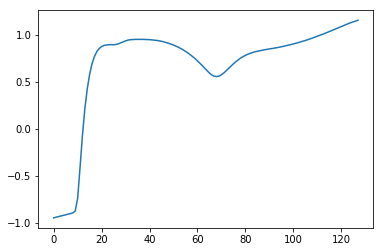

(1000, 128, 3) (1000, 3) (250, 128, 3) (250, 3)


In [16]:
x_train=np.loadtxt('X_train.csv',delimiter=',')
y_train=np.loadtxt('Y_train.csv',delimiter=',')
x_test=np.loadtxt('X_test.csv',delimiter=',')
y_test=np.loadtxt('Y_test.csv',delimiter=',')

mean=np.mean(x_train,axis=0)
std=np.std(x_train,axis=0)
x_train=(x_train-mean)/std
x_test=(x_test-mean)/std
x_train=np.reshape(x_train,(-1,128,3))
x_test=np.reshape(x_test,(-1,128,3))
#x_train=np.expand_dims(x_train, axis=2)
#x_test=np.expand_dims(x_test, axis=2)

plt.plot(x_train[3,:,1])
plt.show()
'''y_train=np.log10(y_train)
y_test=np.log10(y_test)
y_train[:,1]=y_train[:,1]+1
y_test[:,1]=y_test[:,1]+1'''
max=np.max(y_train,axis=0)
y_train=y_train/max
y_test=y_test/max

print(np.shape(x_train),np.shape(y_train),np.shape(x_test),np.shape(y_test))

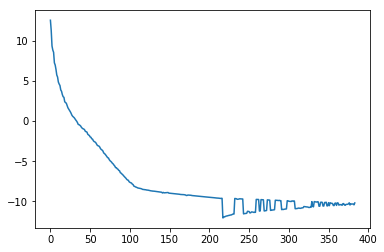

(1000, 3)


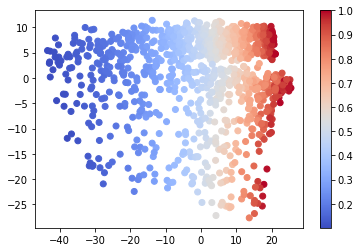

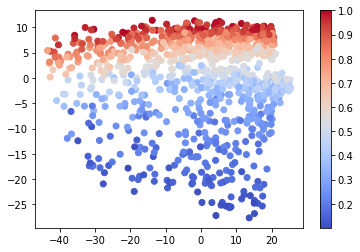

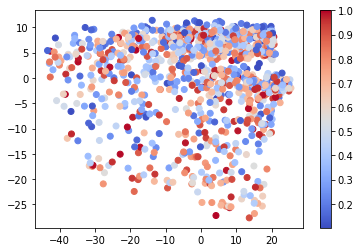

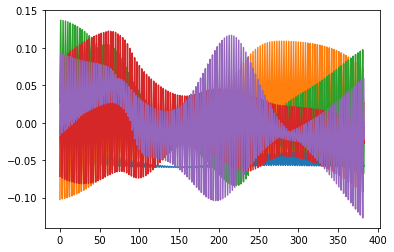

In [11]:
#Data Analysis
X = np.reshape(x_train,(-1,128*3))
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
X_=np.matrix.transpose(X)

lambd,W=np.linalg.eig(np.matmul(X_,X))

plt.plot(np.log(lambd))
plt.show()

Z=np.matmul(X,W[:,:3])
print(np.shape(Z))

sc=plt.scatter(Z[:,0],Z[:,1], c=y_train[:,0], cmap="coolwarm")
plt.colorbar()
plt.savefig('Sigma_PCA.png')
plt.show()

sc=plt.scatter(Z[:,0],Z[:,1], c=y_train[:,1], cmap="coolwarm")
plt.colorbar()
plt.savefig('Eth_PCA.png')
plt.show()

sc=plt.scatter(Z[:,0],Z[:,1], c=y_train[:,2], cmap="coolwarm")
plt.colorbar()
plt.savefig('Slope_PCA.png')
plt.show()


for i in range(5):
    plt.plot(W[:,i])
plt.show()


In [4]:
model = Sequential()

model.add(Conv1D(filters = 16, kernel_size = 6, activation='relu', input_shape = (128,3)))
model.add(BatchNormalization())
#model.add(Conv1D(filters = 16, kernel_size = 3, activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv1D(filters = 16, kernel_size = 3, activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool1D(strides=2))
model.add(Dropout(0.25))

model.add(Conv1D(filters = 32, kernel_size = 6, activation='relu'))
model.add(BatchNormalization())
#model.add(Conv1D(filters = 32, kernel_size = 3, activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv1D(filters = 32, kernel_size = 3, activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool1D(strides=2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1024, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1024, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(3, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer = Adam(lr=1e-4), metrics=["accuracy"]) #binary_crossentropy

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

hist = model.fit(x=x_train, y=y_train, batch_size=512,
                           epochs=40, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_test, y_test), #For speed
                           callbacks=[annealer])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


ValueError: Error when checking input: expected conv1d_1_input to have shape (128, 1) but got array with shape (384, 1)

In [ ]:
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
for i in range(3):
    plt.scatter(model.predict(x_train)[:,i],y_train[:,i])
    plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
    plt.show()

In [ ]:
for i in range(3):
    plt.scatter(model.predict(x_test)[:,i],y_test[:,i])
    plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
    plt.show()